Prepared by **Valerian Pratama (20121003)**

# Daftar Isi

1. [Daftar Isi](#Daftar-Isi)
2. [Pendahuluan](#Pendahuluan)
3. [Persiapan Data](#Persiapan-Data-dan-Analisis-Pendahuluan)
4. [Model Ordinary Least Square](#Model-OLS)
5. [MLP dengan Aktivasi ReLU](#Multilayer-Perceptron-Dengan-Aktivasi-ReLU-(Featuring-sklearn))
6. [MLP dengan Aktivasi Linear](#MLP-dengan-Fungsi-Aktivasi-Linear)
7. [Kesimpulan](#Kesimpulan)
8. [Referensi](#Referensi)

# Pendahuluan

Pada folder yang sama dengan dokumen ini telah disertakan tiga buah file ```.csv``` berisikan harga saham PT Barito Putra (BRPT), PT Lippo Cikarang (LPCK), dan PT Indofood CBP Sukses Makmur (ICBP). Data tersebut diunduh dari Yahoo Finance pada tanggal 3 Desember 2021 (WIB).

Dokumen ini terbagi atas beberapa *section*. Pertama, kita akan melakukan persiapan data untuk proses pemodelan kita. Lalu, disertakan pula plot ACF dan pACF dari masing-masing harga saham. Plot ini akan berguna jika kita melakukan pemodelan menggunakan ARIMA, tetapi kita tidak menyertakan hal tersebut untuk saat ini. Namun, dengan melihat pACF, kita bisa menyimpulkan (secara kualitatif) bahwa data-data tersebut dapat kita modelkan dengan proses $AR(1)$. Inilah yang menjadi landasan kita dalam melakukan pemodelan dengan OLS pada *section* selanjutnya. 

Setelah menggunakan estimator OLS, kita berlanjut mengeksplorasi model *deep learning*. Bagian ini kita pecah menjadi dua buah *section*. Pertama adalah model MLP dengan fungsi aktivasi ReLU dan kedua adalah MLP dengan fungsi aktivasi identitas/linear. Pada kedua *section*, kita tetap memilih menggunakan satu buah *hidden layer* karena setelah ekspermen, hasilnya tidak jauh berbeda (dalam MSE). Dengan demikian, kita pilih yang lebih sederhana.

Terakhir, kita tutup dengan kesimpulan dengan mengumpulkan kembali MSE dari berbagai model yang telah kita cobakan.

# Persiapan Data dan Analisis Pendahuluan

Data yang akan digunakan berasal dari Yahoo Finance. Data yang diinputkan adalah harga saham open, high, low, dan close (serta volume transaksi harian) dari tanggal 3 Desember 2020 hingga 2 Desember 2021. Untuk keperluan pengolahan data kali ini, akan diambil harga closing saham pada suatu hari. Namun, sebelum memasukkan data, akan kita panggil dahulu library yang kita perlukan.

In [187]:
import numpy as np
from numpy.random import *
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [188]:
def steps(x, step):
 obs = len(x)-step
 xt = x[:obs,:]
 for i in np.arange(1,step+1):
     xt = np.hstack((xt, x[i:obs+i,:]))
 return xt

Sekarang, kita akan mengimport datanya. Lalu, kita juga akan menormalkan datanya ke rentang 0 sampai 1 (disimpan dalam variable dengan tambahan ```_adj```

In [319]:
BRPT = pd.read_csv('BRPT.JK.csv').values
BRPT_close = (BRPT[:,4:5].astype(float))
BRPT_adj = (BRPT_close - min(BRPT_close))/(max(BRPT_close - min(BRPT_close)))
xy_BRPT = steps(BRPT_adj, 1)
x_BRPT = xy_BRPT[:,:-1]
x_BRPT = np.hstack((np.ones([len(xy_BRPT),1]), x_BRPT))

LPCK = pd.read_csv('LPCK.JK.csv').values
LPCK_close = (LPCK[:,4:5].astype(float))
LPCK_adj = (LPCK_close - min(LPCK_close))/(max(LPCK_close - min(LPCK_close)))
xy_LPCK = steps(LPCK_adj, 1)
x_LPCK = xy_LPCK[:,:-1]
x_LPCK = np.hstack((np.ones([len(xy_LPCK),1]), x_LPCK))

ICBP = pd.read_csv('ICBP.JK.csv').values
ICBP_close = (ICBP[:,4:5].astype(float))
ICBP_adj = (ICBP_close - min(ICBP_close))/(max(ICBP_close - min(ICBP_close)))
xy_ICBP = steps(ICBP_adj, 1)
x_ICBP = xy_ICBP[:,:-1]
x_ICBP = np.hstack((np.ones([len(xy_ICBP),1]), x_ICBP))

Mari kita intip sedikit plot dari datanya

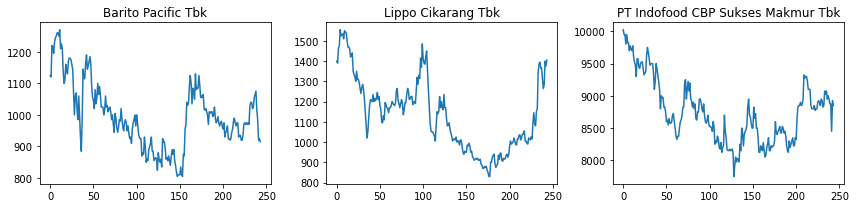

In [320]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
axes[0].plot(BRPT_close)
axes[0].title.set_text('Barito Pacific Tbk')
axes[1].plot(LPCK_close)
axes[1].title.set_text('Lippo Cikarang Tbk')
axes[2].plot(ICBP_close)
axes[2].title.set_text('PT Indofood CBP Sukses Makmur Tbk')
fig.tight_layout()

Kita akan mengambil sebagian datanya untuk training dan sisanya digunakan untuk testing. Sebelumnya, perhatikan dahulu bahwa total data kita ada sebanyak 243 (hari bursa). Kita akan ambil 90%nya, yakni 219 data pertama.

In [321]:
ntrain = 219
ntest = 243 - ntrain

BRPT_train_x = x_BRPT[0:ntrain,:]
BRPT_train_y = xy_BRPT[0:ntrain, -1:]

LPCK_train_x = x_LPCK[0:ntrain,:]
LPCK_train_y = xy_LPCK[0:ntrain, -1:]

ICBP_train_x = x_ICBP[0:ntrain,:]
ICBP_train_y = xy_ICBP[0:ntrain, -1:]

BRPT_test_x = x_BRPT[len(x_BRPT) - ntest:,:]
BRPT_test_y = xy_BRPT[len(x_BRPT) - ntest:,-1:]

LPCK_test_x = x_LPCK[len(x_LPCK) - ntest:,:]
LPCK_test_y = xy_LPCK[len(x_LPCK) - ntest:,-1:]

ICBP_test_x = x_ICBP[len(x_ICBP) - ntest:,:]
ICBP_test_y = xy_ICBP[len(x_ICBP) - ntest:,-1:]

Berikutnya, kita akan menghitung fungsi autokorelasi dari masing-masing saham.

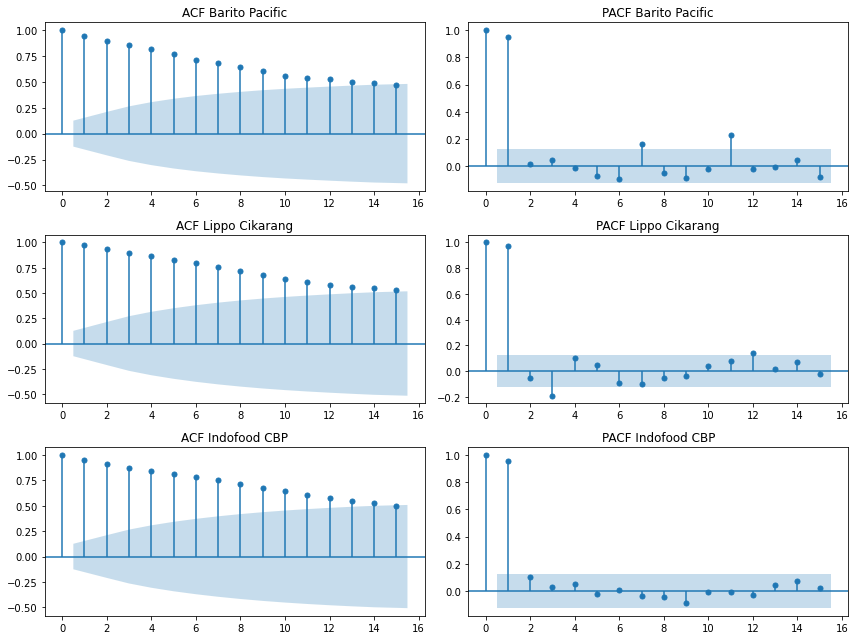

In [322]:
lags_n = 15 #arbitrary

#calculate
acf_BRPT = acf(BRPT_close, adjusted = False, nlags = lags_n, fft = False)
acf_LPCK = acf(LPCK_close, adjusted = False, nlags = lags_n, fft = False)
acf_ICBP = acf(ICBP_close, adjusted = False, nlags = lags_n, fft = False)

#plot
fig, ax = plt.subplots(3,2,figsize=(12,9))
sm.graphics.tsa.plot_acf(BRPT_close, lags=lags_n,fft = False, title = 'ACF Barito Pacific', ax = ax[0,0])
sm.graphics.tsa.plot_pacf(BRPT_close, lags=lags_n, title = 'PACF Barito Pacific', ax = ax[0,1])

sm.graphics.tsa.plot_acf(LPCK_close, lags=lags_n,fft = False, title = 'ACF Lippo Cikarang', ax = ax[1,0])
sm.graphics.tsa.plot_pacf(LPCK_close, lags=lags_n, title = 'PACF Lippo Cikarang', ax = ax[1,1])

sm.graphics.tsa.plot_acf(ICBP_close, lags=lags_n,fft = False, title = 'ACF Indofood CBP', ax = ax[2,0])
sm.graphics.tsa.plot_pacf(ICBP_close, lags=lags_n, title = 'PACF Indofood CBP', ax = ax[2,1])

fig.tight_layout()

# Model OLS

Pada bagian ini, kita akan menggunakan model linear
$$y = X\beta + \varepsilon$$

## Barito Pacific

### Pembentukan Model OLS

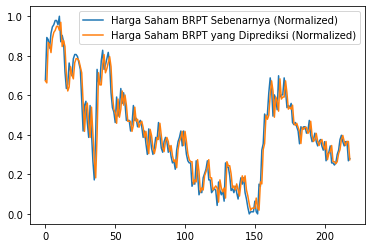

Parameter yang diestimasi model
Beta = 
[[0.0189143]
 [0.9505633]]


In [323]:
#Pertama, estimasi parameter-parameternya

bcap = np.linalg.inv(BRPT_train_x.T@BRPT_train_x)@BRPT_train_x.T@BRPT_train_y
ytraincap = BRPT_train_x@bcap
ecap = BRPT_train_y - ytraincap
mse = ecap.T@ecap/ntrain

#Lalu, plot modelnya
plt.plot(BRPT_train_y, label = 'Harga Saham BRPT Sebenarnya (Normalized)')
plt.plot(ytraincap, label = 'Harga Saham BRPT yang Diprediksi (Normalized)')
plt.legend()
plt.show()

print('Parameter yang diestimasi model')
print('Beta = ')
print(bcap)

### Asesmen Model

Dalam melakukan asesmen, ada dua hal yang dapat kita gunakan. Pertama adalah MSE training dan kedua adalah MSE testing. Dalam kasus kita, karena kita memiliki cukup data, kita dapat mengambil subset datanya menjadi data training dan data testing. Dengan demikian, kita dapat menghitung MSE testing. Namun, secara umum hal ini tidak selalu berlaku. Untuk itulah kita miliki juga MSE training. Dikarenakan *bias-variance tradeoff*, model yang memiliki MSE training terkecil tidak selalu merupakan model yang terbaik. Dapat ditunjukkan bahwa nilai ekspektasi kuadrat dari MSE testing adalah
$$E[Y - \hat{Y}]^2 = Var(\hat{Y}) + \left[Bias\left(\hat{Y}^2\right)\right] + Var(\varepsilon)$$
Salah satu ciri dari model yang *overfit* adalah tingginya variansi. Dengan demikian, apabila terjadi *overfit*, MSE testing juga akan meningkat. Informasi ini tidak tergambarkan dalam MSE training. [1](#Referensi)

Pada bahasan kita, kita akan cenderung memperhatikan MSE testing jika mungkin ketika kita memilih model kita. Namun, keduanya, jika mungkin, akan tetap dihitung.

In [360]:
ytestcap = BRPT_test_x@bcap
training_MSE_BRPT = (BRPT_train_y - ytraincap).T@(BRPT_train_y - ytraincap)/len(BRPT_train_y)
test_MSE_BRPT = (BRPT_test_y - ytestcap).T@(BRPT_test_y - ytestcap)/len(BRPT_test_y)

print('MSE Training: %8.7f'%training_MSE_BRPT)
print('MSE Testing: %8.7f'%test_MSE_BRPT)

MSE Training: 0.0634998
MSE Testing: 0.0030093


## Lippo Cikarang
Metodenya serupa, jadi tidak akan diberikan terlalu banyak komentar lebih lanjut di sini.

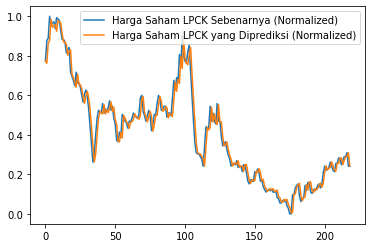

Parameter yang diestimasi model
Beta = 
[[0.00651327]
 [0.97822919]]
MSE Training: 0.0021655
MSE Testing: 0.0060014


In [359]:
#Pertama, estimasi parameter-parameternya

bcap = np.linalg.inv(LPCK_train_x.T@LPCK_train_x)@LPCK_train_x.T@LPCK_train_y
ytraincap = LPCK_train_x@bcap
ecap = LPCK_train_y - ytraincap
mse = ecap.T@ecap/ntrain

#Lalu, plot modelnya
plt.plot(LPCK_train_y, label = 'Harga Saham LPCK Sebenarnya (Normalized)')
plt.plot(ytraincap, label = 'Harga Saham LPCK yang Diprediksi (Normalized)')
plt.legend()
plt.show()

print('Parameter yang diestimasi model')
print('Beta = ')
print(bcap)

ytestcap = LPCK_test_x@bcap
training_MSE_LPCK = (LPCK_train_y - ytraincap).T@(LPCK_train_y - ytraincap)/len(LPCK_train_y)
test_MSE_LPCK = (LPCK_test_y - ytestcap).T@(LPCK_test_y - ytestcap)/len(LPCK_test_y)

print('MSE Training: %8.7f'%training_MSE_LPCK)
print('MSE Testing: %8.7f'%test_MSE_LPCK)

## Indofood CBP

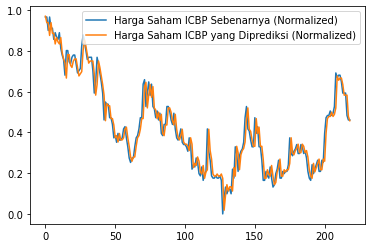

Parameter yang diestimasi model
Beta = 
[[0.0180042 ]
 [0.95274558]]
MSE Training: 0.0031880
MSE Testing: 0.0041673


In [361]:
#Pertama, estimasi parameter-parameternya

bcap = np.linalg.inv(ICBP_train_x.T@ICBP_train_x)@ICBP_train_x.T@ICBP_train_y
ytraincap = ICBP_train_x@bcap
ecap = ICBP_train_y - ytraincap
mse = ecap.T@ecap/ntrain

#Lalu, plot modelnya
plt.plot(ICBP_train_y, label = 'Harga Saham ICBP Sebenarnya (Normalized)')
plt.plot(ytraincap, label = 'Harga Saham ICBP yang Diprediksi (Normalized)')
plt.legend()
plt.show()

print('Parameter yang diestimasi model')
print('Beta = ')
print(bcap)

ytestcap = ICBP_test_x@bcap
training_MSE_ICBP = (ICBP_train_y - ytraincap).T@(ICBP_train_y - ytraincap)/len(ICBP_train_y)
test_MSE_ICBP = (ICBP_test_y - ytestcap).T@(ICBP_test_y - ytestcap)/len(ICBP_test_y)

print('MSE Training: %8.7f'%training_MSE_ICBP)
print('MSE Testing: %8.7f'%test_MSE_ICBP)

# Multilayer Perceptron Dengan Aktivasi ReLU (Featuring ```sklearn```)

Untuk membangun model perceptron, kita akan memanfaatkan bantuan dari *package* ```sklearn```. Beberapa parameter dari MLPRegressor yang kita perhatikan ialah:
- ```hidden_layer_sizes```: banyaknya neuron pada suatu *hidden layer*
- ```random_state```: jika nilainya 1, ia akan menginisialisasi weight secara acak. Kita akan membiarkan nilainya 1
- ```max_iter```: banyaknya iterasi yang akan dijalankan MLPRegressor. Sebagai perhatian, MLPRegressor akan membagi ```max_iter``` dengan 5 tiap kali pada suatu epoch modelnya gagal mengurangi MSEnya sebesar ```tol```
- ```tol```: besarnya toleransi untuk proses optimisasi
- ```activation```: fungsi aktivasi yang dipilih. Di sini kita menggunakan ReLU
- ```solver```: fungsi pengoptimasi yang digunakan untuk meminimalkan *loss*. Defaultnya adalah Adam. [2](#Referensi)

Perhatikan bahwa di sini kita tak eksplisit menyebutkan banyaknya *hidden layer*. Banyak *hidden layer* ditentukan dari dimensionalitas ```hidden_layer_sizes```. Sebagai contoh, jika kita memasukkan ```hidden_layer_sizes = (n1, n2, n3)```, MLPRegressor akan membentuk model MLP dengan tiga buah *hidden layer* yang pada *layer* pertama memuat ```n1``` buah neuron, *layer* kedua memuat ```n2``` buah neuron, dan seterusnya.

In [341]:
from sklearn.neural_network import MLPRegressor

neurons_count = 120

## Barito Pacific

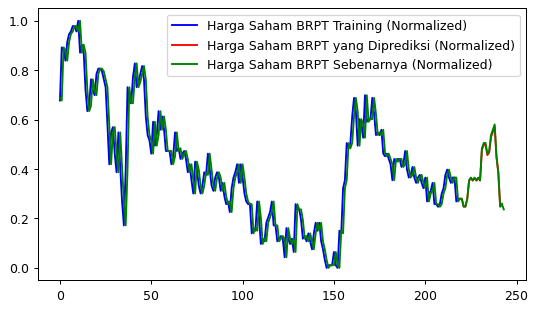

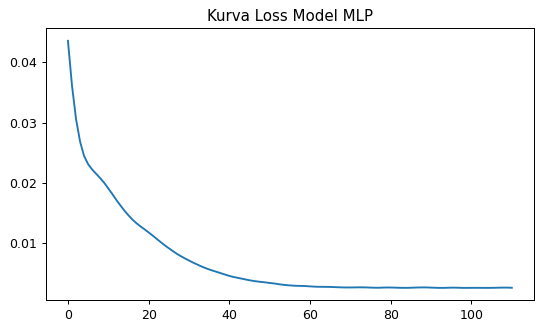

MSE Model MLP 3 layer = 0.00253205


In [354]:
BRPT_model_MLP = MLPRegressor(
    hidden_layer_sizes = neurons_count,
    random_state = 1,
    max_iter = 1000,
    tol = 1e-8,
    activation = 'relu',
    solver = 'adam').fit(BRPT_train_x, np.ravel(BRPT_train_y))
BRPT_MLP_prediction = BRPT_model_MLP.predict(BRPT_test_x)

plt.figure(figsize=(7,4), dpi = 90)
plt.plot(BRPT_train_y, label = 'Harga Saham BRPT Training (Normalized)', color = 'blue')
plt.plot(np.arange(ntrain, ntrain+ntest), BRPT_MLP_prediction, label = 'Harga Saham BRPT yang Diprediksi (Normalized)', color = 'red')
plt.plot(BRPT_adj, color = 'green', label = 'Harga Saham BRPT Sebenarnya (Normalized)')
plt.legend()
plt.show()
BRPT_model_MLP.score(BRPT_test_x, BRPT_test_y)

plt.figure(figsize=(7,4), dpi = 90)
plt.title('Kurva Loss Model MLP')
plt.plot(BRPT_model_MLP.loss_curve_)
plt.show()
print(f'MSE Model MLP {BRPT_model_MLP.n_layers_} layer = {BRPT_model_MLP.loss_curve_[-1]:.8f}')

## Lippo Cikarang

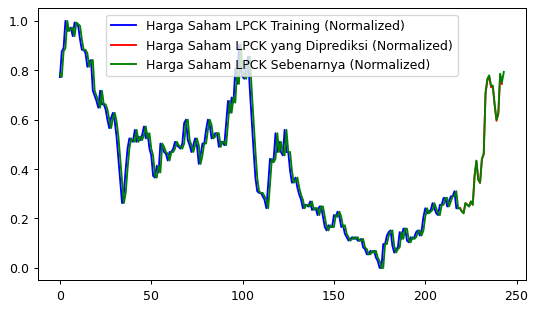

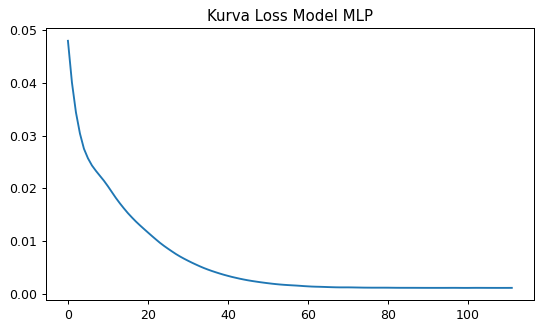

MSE Model MLP 3 layer = 0.00109413


In [347]:
LPCK_model_MLP = MLPRegressor(
    hidden_layer_sizes = neurons_count,
    random_state = 1,
    max_iter = 1000,
    tol = 1e-8,
    activation = 'relu',
    solver = 'adam').fit(LPCK_train_x, np.ravel(LPCK_train_y))

LPCK_MLP_prediction = LPCK_model_MLP.predict(LPCK_test_x)

plt.figure(figsize=(7,4), dpi = 90)
plt.plot(LPCK_train_y, label = 'Harga Saham LPCK Training (Normalized)', color = 'blue')
plt.plot(np.arange(ntrain, ntrain+ntest), LPCK_MLP_prediction, label = 'Harga Saham LPCK yang Diprediksi (Normalized)', color = 'red')
plt.plot(LPCK_adj, color = 'green', label = 'Harga Saham LPCK Sebenarnya (Normalized)')
plt.legend()
plt.show()
LPCK_model_MLP.score(LPCK_test_x, LPCK_test_y)

plt.figure(figsize=(7,4), dpi = 90)
plt.title('Kurva Loss Model MLP dengan Aktivasi Linear')
plt.plot(LPCK_model_MLP.loss_curve_)
plt.show()
print(f'MSE Model MLP {LPCK_model_MLP.n_layers_} layer = {LPCK_model_MLP.loss_curve_[-1]:.8f}')

## Indofood CBP

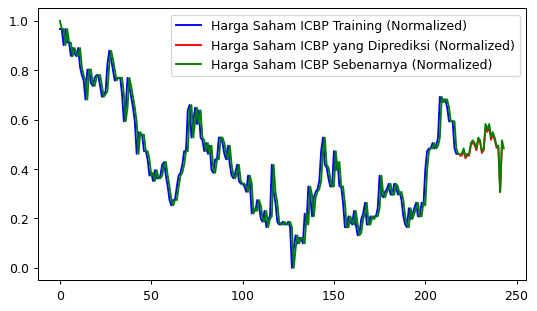

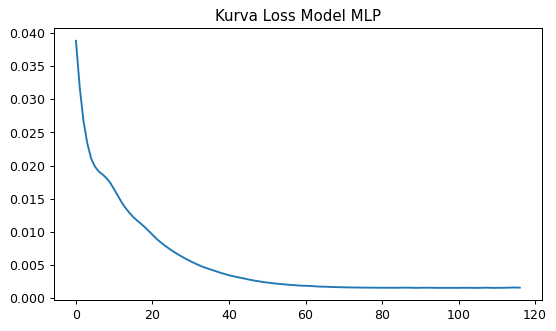

MSE Model MLP 1 hidden layer = 0.00160718


In [346]:
ICBP_model_MLP = MLPRegressor(
    hidden_layer_sizes = neurons_count,
    random_state = 1,
    max_iter = 1000,
    tol = 1e-8,
    activation = 'relu',
    solver = 'adam').fit(ICBP_train_x, np.ravel(ICBP_train_y))
ICBP_MLP_prediction = ICBP_model_MLP.predict(ICBP_test_x)

plt.figure(figsize=(7,4), dpi = 90)
plt.plot(ICBP_train_y, label = 'Harga Saham ICBP Training (Normalized)', color = 'blue')
plt.plot(np.arange(ntrain, ntrain+ntest), ICBP_MLP_prediction, label = 'Harga Saham ICBP yang Diprediksi (Normalized)', color = 'red')
plt.plot(ICBP_adj, color = 'green', label = 'Harga Saham ICBP Sebenarnya (Normalized)')
plt.legend()
plt.show()
ICBP_model_MLP.score(ICBP_test_x, ICBP_test_y)

plt.figure(figsize=(7,4), dpi = 90)
plt.title('Kurva Loss Model MLP')
plt.plot(ICBP_model_MLP.loss_curve_)
plt.show()
print(f'MSE Model MLP {ICBP_model_MLP.n_layers_ - 2} hidden layer = {ICBP_model_MLP.loss_curve_[-1]:.8f}')


# MLP dengan Fungsi Aktivasi Linear

Sebagai bahan eksplorasi, kita akan mencoba menjalankan ```MLPRegressor``` kembali, tetapi dengan menggunakan $f(x) = x$ sebagai fungsi aktivasinya.

## Barito Pacific

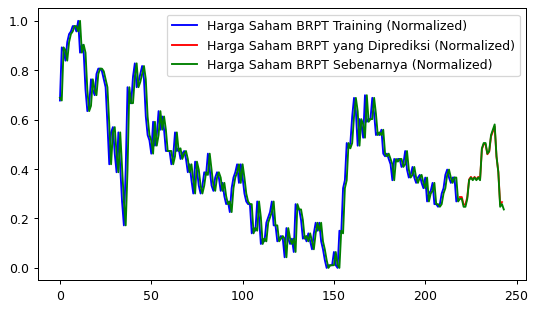

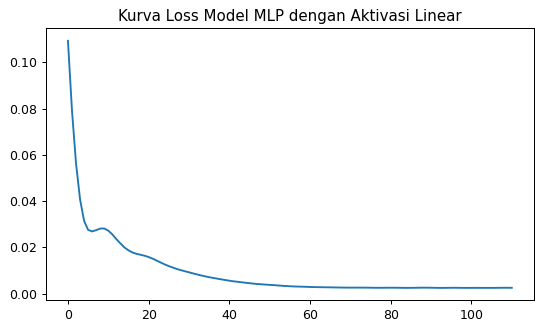

MSE Model MLP 3 layer = 0.00255385


In [355]:
BRPT_model_MLP_linear = MLPRegressor(
    hidden_layer_sizes = neurons_count,
    random_state = 1,
    max_iter = 1000,
    tol = 1e-8,
    activation = 'identity',
    solver = 'adam').fit(BRPT_train_x, np.ravel(BRPT_train_y))
BRPT_MLP_prediction = BRPT_model_MLP_linear.predict(BRPT_test_x)

plt.figure(figsize=(7,4), dpi = 90)
plt.plot(BRPT_train_y, label = 'Harga Saham BRPT Training (Normalized)', color = 'blue')
plt.plot(np.arange(ntrain, ntrain+ntest), BRPT_MLP_prediction, label = 'Harga Saham BRPT yang Diprediksi (Normalized)', color = 'red')
plt.plot(BRPT_adj, color = 'green', label = 'Harga Saham BRPT Sebenarnya (Normalized)')
plt.legend()
plt.show()
BRPT_model_MLP_linear.score(BRPT_test_x, BRPT_test_y)

plt.figure(figsize=(7,4), dpi = 90)
plt.title('Kurva Loss Model MLP dengan Aktivasi Linear')
plt.plot(BRPT_model_MLP_linear.loss_curve_)
plt.show()
print(f'MSE Model MLP {BRPT_model_MLP_linear.n_layers_} layer = {BRPT_model_MLP_linear.loss_curve_[-1]:.8f}')


## Lippo Cikarang

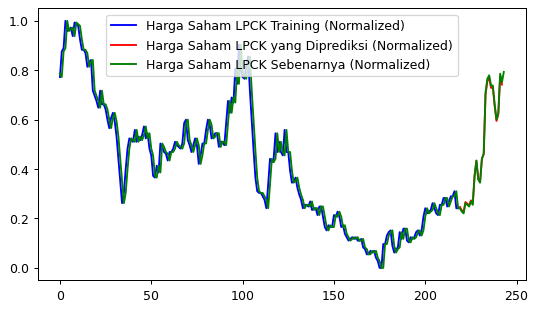

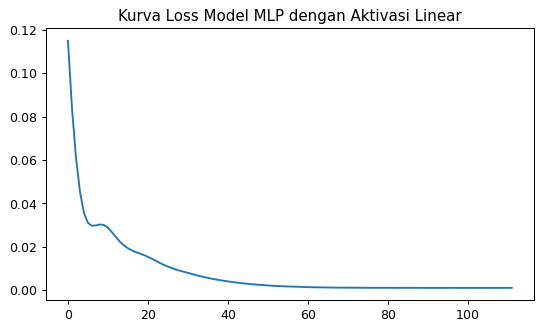

MSE Model MLP 3 layer = 0.00109407


In [369]:
LPCK_model_MLP_linear = MLPRegressor(
    hidden_layer_sizes = neurons_count,
    random_state = 1,
    max_iter = 1000,
    tol = 1e-8,
    activation = 'identity',
    solver = 'adam').fit(LPCK_train_x, np.ravel(LPCK_train_y))
LPCK_MLP_prediction = LPCK_model_MLP_linear.predict(LPCK_test_x)

plt.figure(figsize=(7,4), dpi = 90)
plt.plot(LPCK_train_y, label = 'Harga Saham LPCK Training (Normalized)', color = 'blue')
plt.plot(np.arange(ntrain, ntrain+ntest), LPCK_MLP_prediction, label = 'Harga Saham LPCK yang Diprediksi (Normalized)', color = 'red')
plt.plot(LPCK_adj, color = 'green', label = 'Harga Saham LPCK Sebenarnya (Normalized)')
plt.legend()
plt.show()
LPCK_model_MLP_linear.score(LPCK_test_x, LPCK_test_y)

plt.figure(figsize=(7,4), dpi = 90)
plt.title('Kurva Loss Model MLP dengan Aktivasi Linear')
plt.plot(LPCK_model_MLP_linear.loss_curve_)
plt.show()
print(f'MSE Model MLP {LPCK_model_MLP_linear.n_layers_} layer = {LPCK_model_MLP_linear.loss_curve_[-1]:.8f}')


## Indofood CBP

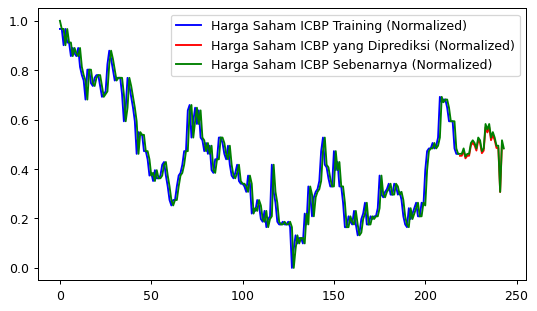

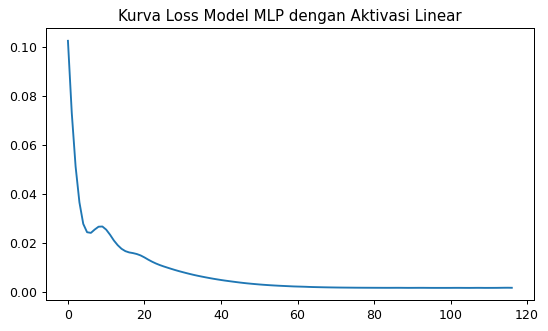

MSE Model MLP 3 layer = 0.00163930


In [370]:
ICBP_model_MLP_linear = MLPRegressor(
    hidden_layer_sizes = neurons_count,
    random_state = 1,
    max_iter = 1000,
    tol = 1e-8,
    activation = 'identity',
    solver = 'adam').fit(ICBP_train_x, np.ravel(ICBP_train_y))
ICBP_MLP_prediction = ICBP_model_MLP_linear.predict(ICBP_test_x)

plt.figure(figsize=(7,4), dpi = 90)
plt.plot(ICBP_train_y, label = 'Harga Saham ICBP Training (Normalized)', color = 'blue')
plt.plot(np.arange(ntrain, ntrain+ntest), ICBP_MLP_prediction, label = 'Harga Saham ICBP yang Diprediksi (Normalized)', color = 'red')
plt.plot(ICBP_adj, color = 'green', label = 'Harga Saham ICBP Sebenarnya (Normalized)')
plt.legend()
plt.show()
ICBP_model_MLP_linear.score(ICBP_test_x, ICBP_test_y)

plt.figure(figsize=(7,4), dpi = 90)
plt.title('Kurva Loss Model MLP dengan Aktivasi Linear')
plt.plot(ICBP_model_MLP_linear.loss_curve_)
plt.show()
print(f'MSE Model MLP {ICBP_model_MLP_linear.n_layers_} layer = {ICBP_model_MLP_linear.loss_curve_[-1]:.8f}')


# Kesimpulan

Dari berbagai model yang telah kita hasilkan, berikut MSEnya (dibagi per saham):

**Barito Putra**

In [367]:
print('MSE Test OLS BRPT: %8.7f'%test_MSE_BRPT)
print(f'MSE MLP ReLU BRPT: {BRPT_model_MLP.loss_curve_[-1]:.7f}')
print(f'MSE MLP Linear BRPT: {BRPT_model_MLP_linear.loss_curve_[-1]:.7f}')

MSE Test OLS BRPT: 0.0030093
MSE MLP ReLU BRPT: 0.0025321
MSE MLP Linear BRPT: 0.0025539


**Lippo Cikarang**

In [371]:
print('MSE Test OLS LPCK: %8.7f'%test_MSE_LPCK)
print(f'MSE MLP ReLU LPCK: {LPCK_model_MLP.loss_curve_[-1]:.7f}')
print(f'MSE MLP Linear LPCK: {LPCK_model_MLP_linear.loss_curve_[-1]:.7f}')

MSE Test OLS LPCK: 0.0060014
MSE MLP ReLU LPCK: 0.0010941
MSE MLP Linear LPCK: 0.0010941


**Indofood CBP**

In [372]:
print('MSE Test OLS ICBP: %8.7f'%test_MSE_ICBP)
print(f'MSE MLP ReLU ICBP: {ICBP_model_MLP.loss_curve_[-1]:.7f}')
print(f'MSE MLP Linear ICBP: {ICBP_model_MLP_linear.loss_curve_[-1]:.7f}')

MSE Test OLS ICBP: 0.0041673
MSE MLP ReLU ICBP: 0.0016072
MSE MLP Linear ICBP: 0.0016393


Dari hasil-hasil di atas, jika patokan kita hanyalah MSE dalam memilih model, kita akan memilih:
- Untuk harga saham BRPT, kita akan memilih model MLP dengan aktivasi ReLU
- Untuk harga saham LPCK, kita akan memilih model MLP dengan aktivasi linear (karena MSEnya sama, pilih yang lebih sederhana)
- Untuk harga saham ICBP, kita akan memilih model MLP dengan aktivasi ReLU

# Referensi
1. “The Bias-Variance Tradeoff in Statistical Machine Learning - the Regression Setting.” *QuantStart*, https://www.quantstart.com/articles/The-Bias-Variance-Tradeoff-in-Statistical-Machine-Learning-The-Regression-Setting/. 
2. “Documentation for Sklearn.neural_network.MLPRegressor.” *Scikit*, https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html.